<a href="https://colab.research.google.com/github/adarshmodh/Deep-Learning-Assignments/blob/master/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Creating dataset

from pathlib import Path
import random
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

To_PIL_Image = transforms.ToPILImage()

class HW2Dataset(torch.utils.data.Dataset):
  def __init__(self,path,transform,train=True):
    self.path = path
    if train==True:
      images_data = np.load(path /'train.npy')
      labels_data = np.load(path /'train_labels.npy')
    else:
      images_data = np.load(path /'test.npy')
      labels_data = np.load(path /'test_labels.npy')
    
    self.transform = transform
    self.valid_labels = [2,5,7]
    self.images_data , self.labels_data = self.preprocessing(images_data,labels_data)
    # self.images_data , self.labels_data = images_data,labels_data
    self.count = len(self.images_data)    

  def preprocessing(self,images, labels):
    valid_labels = self.valid_labels
    processed_images= []
    processed_labels= []

    for ind,label in enumerate(labels):
      if label in valid_labels:
        processed_labels.append(valid_labels.index(label))
        # processed_labels.append(label)
        processed_images.append(images[ind])

    return processed_images, processed_labels    

  def __getitem__(self, index):
    transform = self.transform 
    image = self.images_data[index]
    label = self.labels_data[index]
    return transform(image),label

  def __len__(self):
    count = self.count
    return count # number of images

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


18000 3000


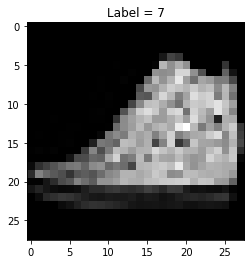

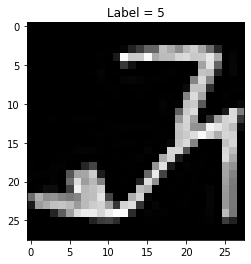

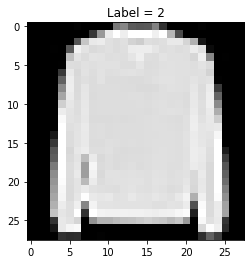

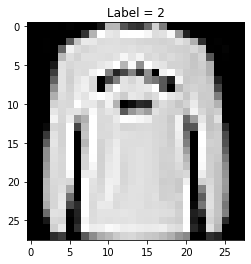

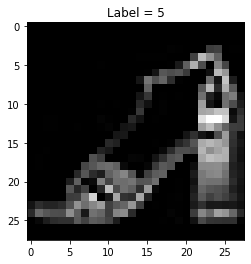

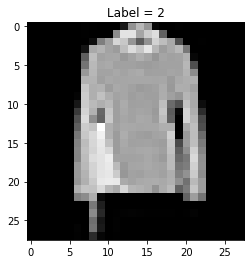

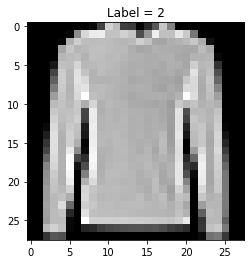

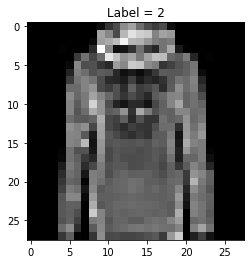

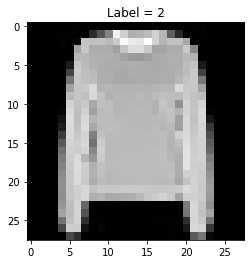

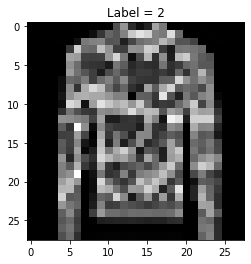

1125 188 3000


In [27]:
import random

#!!!!!!!!!!change to wherever data is located
data_folder = Path("/content/gdrive/My Drive/ESE545_2020/Project_2")

normalize = transforms.Normalize(mean=[0.0],std=[1.0])
transform = transforms.Compose(
        [transforms.ToTensor(),normalize])

trainset = HW2Dataset(data_folder, transform, train=True)
testset = HW2Dataset(data_folder, transform, train=False)
print(len(trainset), len(testset))

for i in range(10):
  index = random.randint(0,len(testset))
  image, label = testset[index]
  plt.imshow(To_PIL_Image(image), cmap='gray')
  plt.title('Label = {}' .format(testset.valid_labels[label]))
  # plt.title('Label = {}' .format(label))
  plt.pause(0.001)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)
sample_testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

print(len(trainloader), len(testloader), len(sample_testloader))

In [0]:
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch import FloatTensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

# Create your network here
class Fashion_MNIST(nn.Module):
  def __init__(self):
    super(Fashion_MNIST , self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=(1,1), bias=True, padding_mode='zeros')
    self.conv1_bn = nn.BatchNorm2d(16)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=(1,1), bias=True, padding_mode='zeros')
    self.conv2_bn = nn.BatchNorm2d(16)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
    self.fc1 = nn.Linear(in_features=16*26*26, out_features=64, bias=True)
    self.fc2 = nn.Linear(in_features=64, out_features=3, bias=True)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = self.pool1(F.relu(self.conv1_bn(self.conv1(x))))
    x = self.pool2(F.relu(self.conv2_bn(self.conv2(x))))
    x = x.flatten(1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = self.softmax(x)
    return x


In [21]:
# Training 

network = Fashion_MNIST().to(device)

loss_criterion = nn.NLLLoss(reduction='mean')

optimizer = optim.Adam(network.parameters(), lr = 0.001)

training_loss=[]
training_acc=[]

validation_loss = []
validation_acc = []

epochs = 15

for e in range(epochs):
    running_loss = 0.0
    running_acc = 0

    #Training 
    for images, labels in trainloader:
        network.train()
        images,labels = images.to(device), labels.to(device)
        # print(images.shape,labels)
        optimizer.zero_grad()        
        output = network(images)
        # print(output.shape)
        loss = loss_criterion(output, labels)
        loss.backward()
        optimizer.step()
  
        running_loss += loss.item()
         
        pred_labels = torch.argmax(torch.exp(output), dim=1)
        # print(pred_labels,labels)
        running_acc += torch.sum(pred_labels == labels).float()/labels.shape[0]
        # print(running_acc, len(trainloader))
        
    else:
        training_acc.append(running_acc/len(trainloader))
        training_loss.append(running_loss/len(trainloader))
        print("Epoch {} - Training loss: {}".format(e, training_loss[-1]))
        
        #Testing
        test_running_loss = 0.0
        test_running_acc = 0
        for images,labels in testloader:
          images,labels = images.to(device), labels.to(device)
          with torch.no_grad():
            network.eval()
            output = network(images)
            loss = loss_criterion(output,labels)
            test_running_loss += loss.item()
            pred_labels = torch.argmax(torch.exp(output),dim=1)
            test_running_acc += torch.sum(pred_labels == labels).float()/labels.shape[0]

        validation_loss.append(test_running_loss/len(testloader))
        validation_acc.append(test_running_acc/len(testloader))
        print("Epoch {} - Testing acc: {}".format(e, validation_acc[-1]))

torch.save(network.state_dict(), data_folder / 'fmnist2.pt')

Epoch 0 - Training loss: 0.0730370023161328
Epoch 0 - Testing acc: 0.948803186416626
Epoch 1 - Training loss: 0.030032640007168893
Epoch 1 - Testing acc: 0.9893617033958435
Epoch 2 - Training loss: 0.02347723398925478
Epoch 2 - Testing acc: 0.9870345592498779
Epoch 3 - Training loss: 0.019291433553046872
Epoch 3 - Testing acc: 0.9883643388748169
Epoch 4 - Training loss: 0.01710362926123662
Epoch 4 - Testing acc: 0.9920212626457214
Epoch 5 - Training loss: 0.013103346188195933
Epoch 5 - Testing acc: 0.9950132966041565
Epoch 6 - Training loss: 0.008370099969411545
Epoch 6 - Testing acc: 0.9953457713127136
Epoch 7 - Training loss: 0.00923530723842805
Epoch 7 - Testing acc: 0.993018627166748
Epoch 8 - Training loss: 0.006794665783821472
Epoch 8 - Testing acc: 0.9923537373542786
Epoch 9 - Training loss: 0.006719890668124274
Epoch 9 - Testing acc: 0.9953457713127136
Epoch 10 - Training loss: 0.006441038336617802
Epoch 10 - Testing acc: 0.9953457713127136
Epoch 11 - Training loss: 0.004748063

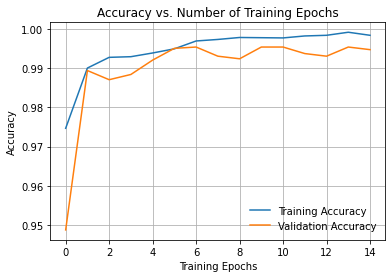

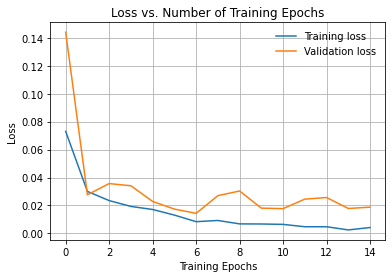

In [22]:
# Plot training and validation curves
plt.figure(0)
plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(training_acc, label='Training Accuracy')
plt.plot(validation_acc, label='Validation Accuracy')
plt.legend(frameon=False)
plt.grid()
plt.show()

plt.figure(1)
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.legend(frameon=False)
plt.grid()
plt.show()

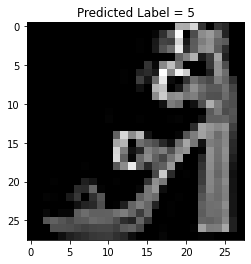

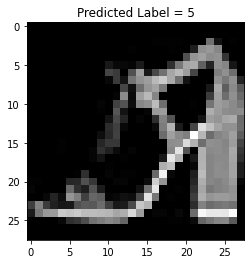

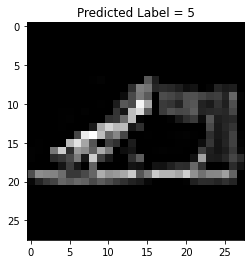

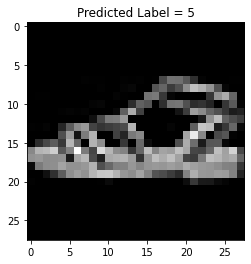

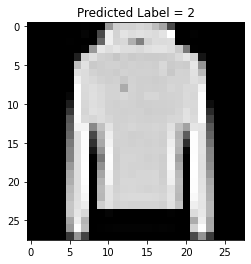

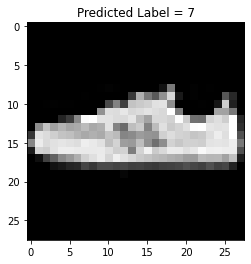

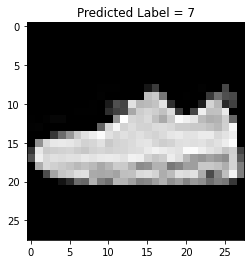

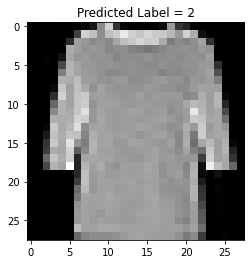

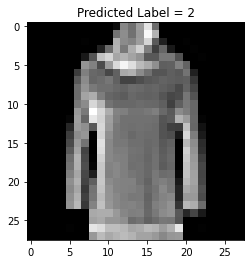

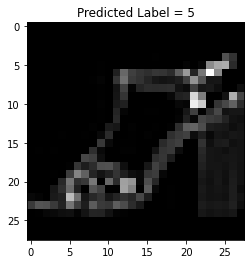

In [31]:
# test your model

network.load_state_dict(torch.load(data_folder / 'fmnist2.pt'))
network.eval()

num_test_samples = 10

for images,labels in sample_testloader:
  if num_test_samples:
    images,labels = images.to(device), labels.to(device)
    with torch.no_grad():
      output = network(images)
      pred_label = torch.argmax(torch.exp(output),dim=1)
      # print(pred_label,images.shape)
      plt.imshow(To_PIL_Image(images.squeeze()), cmap='gray')
      plt.title('Predicted Label = {}' .format(testset.valid_labels[pred_label]))
      # plt.title('Label = {}' .format(label))
      plt.pause(0.001)
      num_test_samples -= 1

    